# The Algorithmic Beauty of Nature

This F# notebook contains implementations, examples, drawings, etc. of the Lindenmayer systems (L-systems) described in the book *The Algorithmic Beauty of Plants* by Przemyslaw Prusinkiewicz and Aristid Lindenmayer.

### Dependencies

In [92]:
#r "nuget: SkiaSharp"

open SkiaSharp

Installed Packages SkiaSharp, 2.88.3

### Utilities

In [93]:
/// Represents angles in degrees
[<Measure>] type degrees

/// Represents angles in radians
[<Measure>] type radians

/// Removes any units of measure from the given float
let removeUnits (x: float<_>) = float x

/// Converts the angle in degrees to radians
let convertDegreesToRadians (degrees: float<degrees>) =
    (degrees * System.Math.PI / 180.0<degrees>) * 1.0<radians>

### Deterministic Context Free (DOL) System

In Section 1.2 on pages 3-6, DOL-systems are described.

**Definition**: Let $V$ denote an alphabet, $V^*$ the set of all words over $V$, and $V^+$ the set of all nonempty words over $V$. A *string OL-system* is an ordered triplet $G = \langle V, \omega, P \rangle$ where $V$ is the *alphabet* of the system, $\omega\in V^+$ is a nonempty word called the *axiom* and $P\subset V\times V^*$ is a finite *set of productions*. A production $(a, \chi)\in P$ is written as $a \to \chi$. The letter $a$ and the word $\chi$ are called the *predecessor* and the *successor* of this production, respectively. It is assumed that for any letter $a\in V$, there is at least one word $\chi\in V^*$ such that $a\to \chi$. If no production is explicitly specified for a given predecessor $a\in V$, the *identity production* $a \to a$ is assumed to belong to the set of productions $P$. An OL-system is *deterministic* (noted *DOL-system*) if and only if for each $a\in V$ there is exactly one $\chi\in V^*$ such that $a\to V$.

In [94]:
type Production =
    { Predecessor: char
      Successor: string }

let production (predecessor, successor) =
    { Predecessor = predecessor
      Successor = successor }

type DOLSystem =
    { Alphabet: char list
      Axiom: string
      Productions: Production list }

let verifyDeterminism dol =
    let predecessors =
        dol.Productions
        |> List.map (fun p -> p.Predecessor)
    (List.length predecessors) = (predecessors |> List.distinct |> List.length)

let rewriteCharacter productions character =
    match List.tryFind (fun p -> p.Predecessor = character) productions with
    | Some {Successor = sucessor} -> sucessor
    | None -> string character

let rewriteWord productions (word: string) =
    let stringSequence = Seq.map (rewriteCharacter productions) word
    String.Join("", stringSequence)

let iterate n dol =
    List.fold (fun word _ -> rewriteWord dol.Productions word) dol.Axiom [1..n]

let printIterations n dol =
    for i in [0..n] do
        printfn "%s" (iterate i dol)

let testProduction character =
    match character with
    | 'b' -> "ad"
    | 'a' -> "cb"
    | 'd' -> "b"
    | 'c' -> "a"
    | x   -> string x

The following DOL-system example is that found in (1.1). In the current implementation of `DOLSystem`, we cannot represent characters such as $a_r$ since we are restricted to an alphabet consisting only of characters. To do something like `a_r` would required extending alphabet entries to strings, which would require more complex modeling and logic than we currently have in place. So, for now, $a_l$ is `a`, $a_r$ is `b`, $b_l$ is `c`, and $b_r$ is `d`.

In [95]:
let dol =
    { Alphabet = ['a'; 'b'; 'c'; 'd']
      Axiom = "b"
      Productions =
        [ production ('b', "ad")
          production ('a', "cb")
          production ('d', "b")
          production ('c', "a") ] }

printIterations 4 dol

b
ad
cbb
aadad
cbcbbcbb


We can use `MathString` provided by .NET Interactive to display a $\LaTeX$ string and reproduce the output in the book on page 5.

In [96]:
[ for n in [0..4] ->
    (iterate n dol)
        .Replace("a", "a_l")
        .Replace("b", "a_r")
        .Replace("c", "b_l")
        .Replace("d", "b_r") ]
|> (fun s -> String.Join(@"\\", s))
|> MathString

In [97]:
let quadraticKochIsland =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "F-F+F+FF-F-F+F") ] }

printIterations 1 quadraticKochIsland

F-F-F-F
F-F+F+FF-F-F+F-F-F+F+FF-F-F+F-F-F+F+FF-F-F+F-F-F+F+FF-F-F+F


In [98]:
type Coordinate =
    { X: float
      Y: float }

type TurtleCommand =
    | ForwardWithPenDown
    | ForwardWithPenUp
    | RotateRight
    | RotateLeft

type Turtle =
    { Coordinate: Coordinate
      Heading: float<degrees>
      StepSize: float
      AngleIncrement: float<degrees> }

let defaultTurtle =
    { Coordinate = {X = 0.0; Y = 0.0}
      Heading = 90.0<degrees>
      StepSize = 50.0
      AngleIncrement = 90.0<degrees> }

let handleCommand state command =
    match command with
    | ForwardWithPenDown ->
        let nextX = state.Coordinate.X + state.StepSize * cos (state.Heading |> convertDegreesToRadians |> removeUnits)
        let nextY = state.Coordinate.Y + state.StepSize * sin (state.Heading |> convertDegreesToRadians |> removeUnits)
        { state with Coordinate = {X = nextX; Y = nextY} }
    | ForwardWithPenUp ->
        let nextX = state.Coordinate.X + state.StepSize * cos (state.Heading |> convertDegreesToRadians |> removeUnits)
        let nextY = state.Coordinate.Y + state.StepSize * sin (state.Heading |> convertDegreesToRadians |> removeUnits)
        { state with Coordinate = {X = nextX; Y = nextY} }
    | RotateRight ->
        { state with Heading = state.Heading - state.AngleIncrement }
    | RotateLeft ->
        { state with Heading = state.Heading + state.AngleIncrement }

let drawTurtle (path: SKPath) command state =
    let newState = handleCommand state command
    match command with
    | ForwardWithPenDown ->
        path.LineTo(single newState.Coordinate.X, single newState.Coordinate.Y)
        newState
    | ForwardWithPenUp ->
        path.MoveTo(single newState.Coordinate.X, single newState.Coordinate.Y)
        newState
    | RotateRight ->
        newState
    | RotateLeft ->
        newState

let calculateExtremeCoordinates initialTurtle commands =
    let handleState (turtle, minX, minY, maxX, maxY) command =
        let newTurtle = handleCommand turtle command
        (newTurtle, min minX newTurtle.Coordinate.X, min minY newTurtle.Coordinate.Y, max maxX newTurtle.Coordinate.X, max maxY newTurtle.Coordinate.Y)
    let (_, minX, minY, maxX, maxY) =
        List.fold handleState (initialTurtle, initialTurtle.Coordinate.X, initialTurtle.Coordinate.Y, initialTurtle.Coordinate.X, initialTurtle.Coordinate.Y) commands
    ({X = minX; Y = minY}, {X = maxX; Y = maxY})

let drawSystem (canvas: SKCanvas) initialTurtle commands =
    let ({Coordinate.X = minX; Y = minY}, {Coordinate.X = maxX; Y = maxY}) = calculateExtremeCoordinates initialTurtle commands
    let turtleColor = SKColors.Black
    use turtlePaint = new SKPaint(
        Style = SKPaintStyle.Stroke,
        Color = SKColors.Black,
        StrokeWidth = 1.0f)
    use originPaint = new SKPaint(
        Style = SKPaintStyle.Stroke,
        Color = SKColors.LawnGreen,
        StrokeWidth = 10.0f,
        StrokeCap = SKStrokeCap.Round)
    canvas.Clear(SKColors.WhiteSmoke)
    //canvas.Translate(500.0f, 500.f)
    canvas.Translate(single -minX, single maxY)
    canvas.RotateDegrees(180.0f)
    canvas.Scale(-1.0f, 1.0f, 0.0f, 0.0f)
    canvas.DrawPoint(single initialTurtle.Coordinate.X, single initialTurtle.Coordinate.Y, originPaint)


    use path = new SKPath()
    path.MoveTo(single initialTurtle.Coordinate.X, single initialTurtle.Coordinate.Y)
    let mutable state = initialTurtle
    for command in commands do
        //printfn "Drawing command: %A" command
        state <- drawTurtle path command state
    //path.Close()
    canvas.DrawPath(path, turtlePaint)

In [99]:
let convertTurtleStringToCommands (s: string) =
    [for c in s.Replace(" ", String.Empty) ->
        match c with
        | 'F' -> ForwardWithPenDown
        | 'f' -> ForwardWithPenUp
        | '+' -> RotateLeft
        | '-' -> RotateRight
        | _ -> raise (System.Exception "invalid turtle character")]

let drawTurtleSystem n initialTurtle dol : SKBitmap =
    let margin = 10.0
    let adjustedStepSize =
        if n = 0 then
            initialTurtle.StepSize
        else
            initialTurtle.StepSize / float (n*n)
    let initialTurtle = { initialTurtle with StepSize = adjustedStepSize }
    let commands =
        dol
        |> iterate n
        |> convertTurtleStringToCommands
    let ({Coordinate.X = minX; Y = minY}, {Coordinate.X = maxX; Y = maxY}) = calculateExtremeCoordinates initialTurtle commands
    let bitmap = new SKBitmap(maxX - minX + 2.0 * margin |> ceil |> int, maxY - minY + 2.0 * margin |> ceil |> int)
    use canvas = new SKCanvas(bitmap)
    canvas.Translate(single margin, single margin)
    drawSystem canvas initialTurtle commands
    bitmap


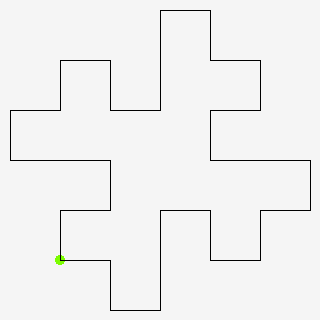

In [100]:
drawTurtleSystem 1 defaultTurtle quadraticKochIsland


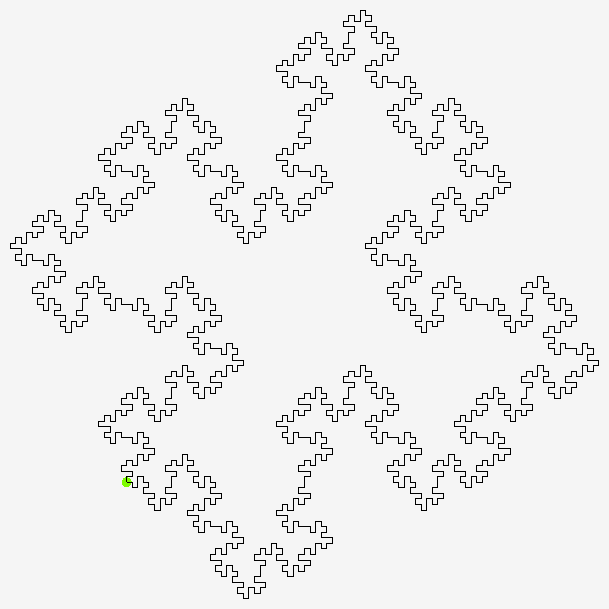

In [101]:
drawTurtleSystem 3 defaultTurtle quadraticKochIsland


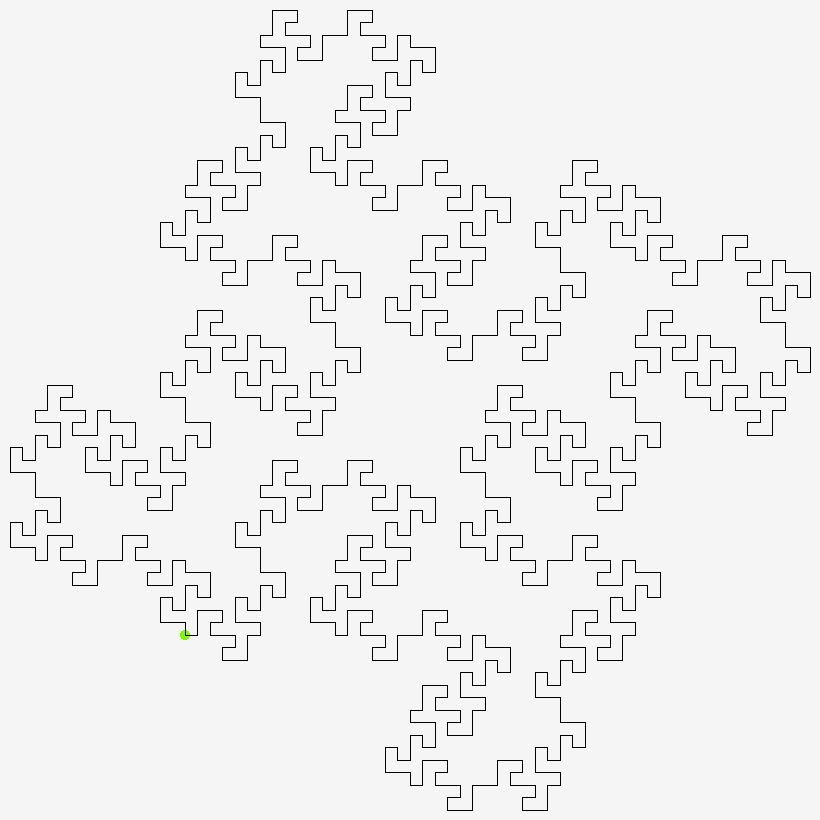

In [102]:
// Figure 1.7 (a)
let quadraticKochIsland =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "F+FF-FF-F-F+F+FF-F-F+F+FF+FF-F") ] }

drawTurtleSystem 2 defaultTurtle quadraticKochIsland


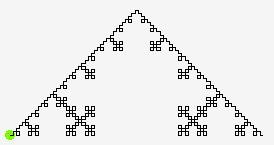

In [103]:
// Figure 1.7 (b)
let quadraticSnowflakeCurve =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "-F"
      Productions =
        [ production ('F', "F+F-F-F+F") ] }

drawTurtleSystem 4 defaultTurtle quadraticSnowflakeCurve


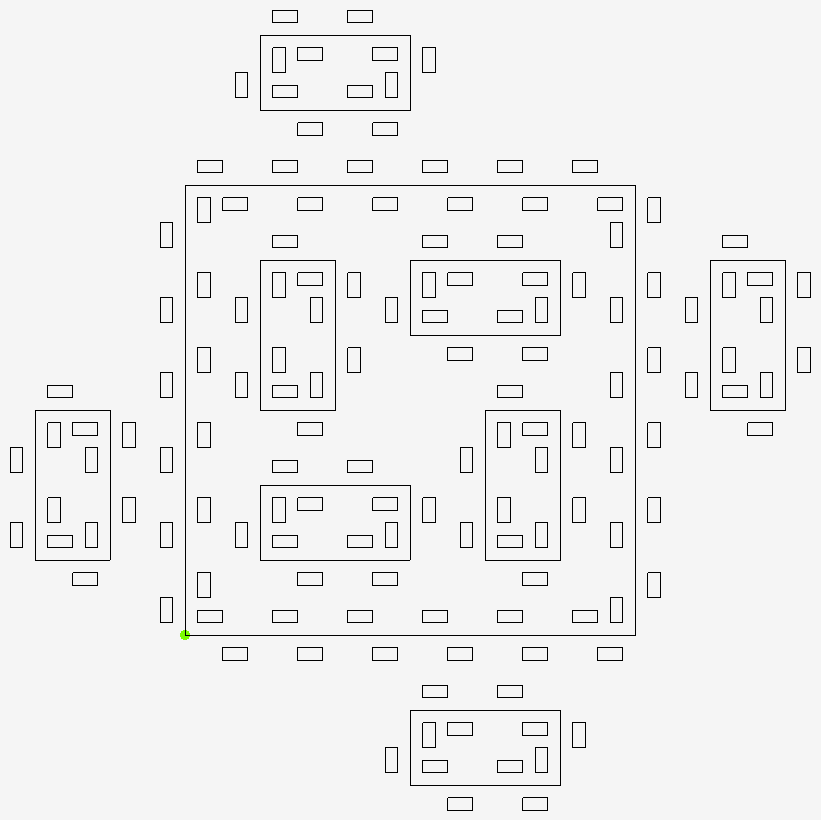

In [104]:
// Figure 1.8
let islandsAndLakes =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "F+f-FF+F+FF+Ff+FF-f+FF-F-FF-Ff-FFF")
          production ('f', "ffffff") ] }

drawTurtleSystem 2 defaultTurtle islandsAndLakes


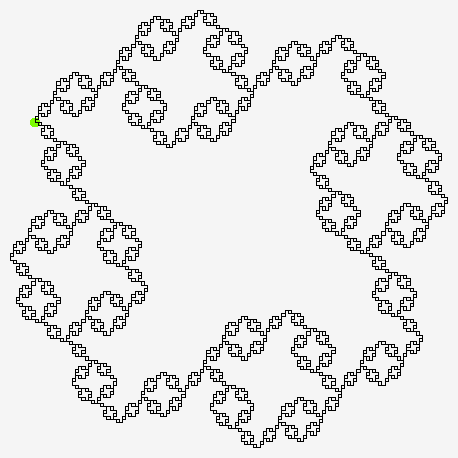

In [105]:
// Figure 1.9 (a)
let kochA =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "FF-F-F-F-F-F+F") ] }

drawTurtleSystem 4 defaultTurtle kochA


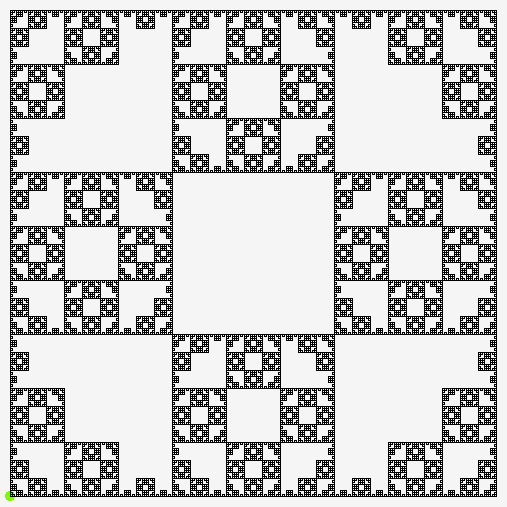

In [106]:
// Figure 1.9 (b)
let kochB =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "FF-F-F-F-FF") ] }

drawTurtleSystem 5 defaultTurtle kochB


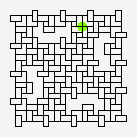

In [107]:
// Figure 1.9 (c)
let kochC =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "FF-F+F-F-FF") ] }

drawTurtleSystem 3 defaultTurtle kochC


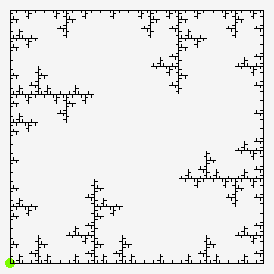

In [108]:
// Figure 1.9 (d)
let kochD =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "FF-F--F-F") ] }

drawTurtleSystem 4 defaultTurtle kochD


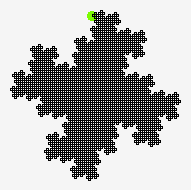

In [109]:
// Figure 1.9 (e)
let kochE =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "F-FF--F-F") ] }

drawTurtleSystem 5 defaultTurtle kochE


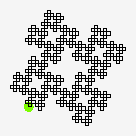

In [110]:
// Figure 1.9 (f)
let kochF =
    { Alphabet = ['F'; 'f'; '+'; '-']
      Axiom = "F-F-F-F"
      Productions =
        [ production ('F', "F-F+F-F-F") ] }

drawTurtleSystem 4 defaultTurtle kochF

### Edge rewriting


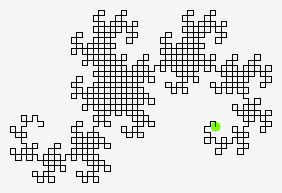

In [111]:
// Figure 1.10 (a)
let dragonCurve =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "L"
      Productions =
        [ production ('L', "L+R+")
          production ('R', "-L-R") ] }

let drawFASSTurtleSystem n initialTurtle fass =
    let s = iterate n fass
    let turtleSystem = { fass with Axiom = s.Replace('L', 'F').Replace('R', 'F') }
    drawTurtleSystem (ceil (float n / 4.0) |> int) initialTurtle turtleSystem

drawFASSTurtleSystem 10 defaultTurtle dragonCurve


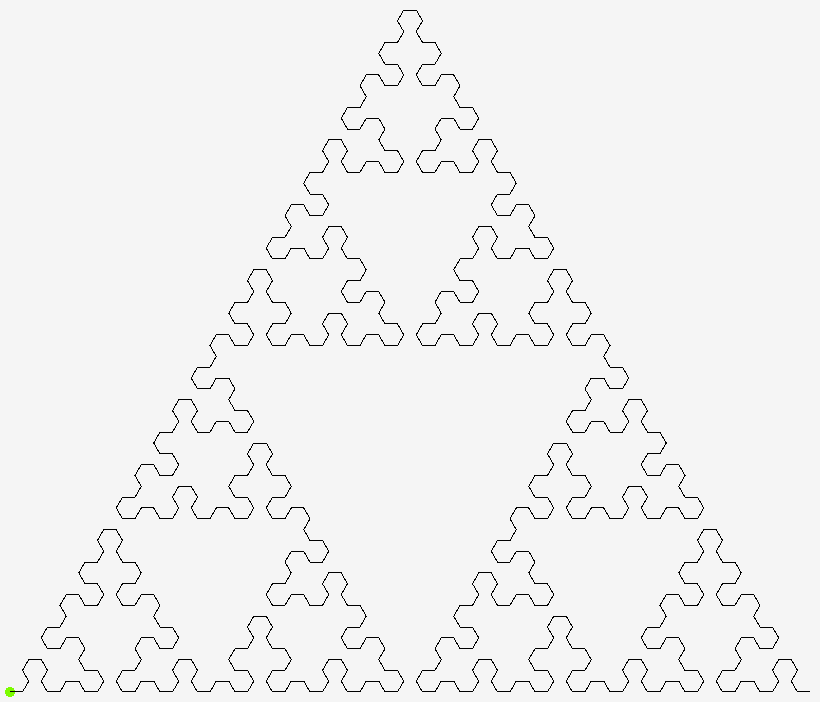

In [112]:
// Figure 1.10 (b)
let sierpinskiGasket =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "R"
      Productions =
        [ production ('L', "R+L+R")
          production ('R', "L-R-L") ] }

drawFASSTurtleSystem 6 {defaultTurtle with Heading = 0.0<degrees>; AngleIncrement = 60.0<degrees>} sierpinskiGasket


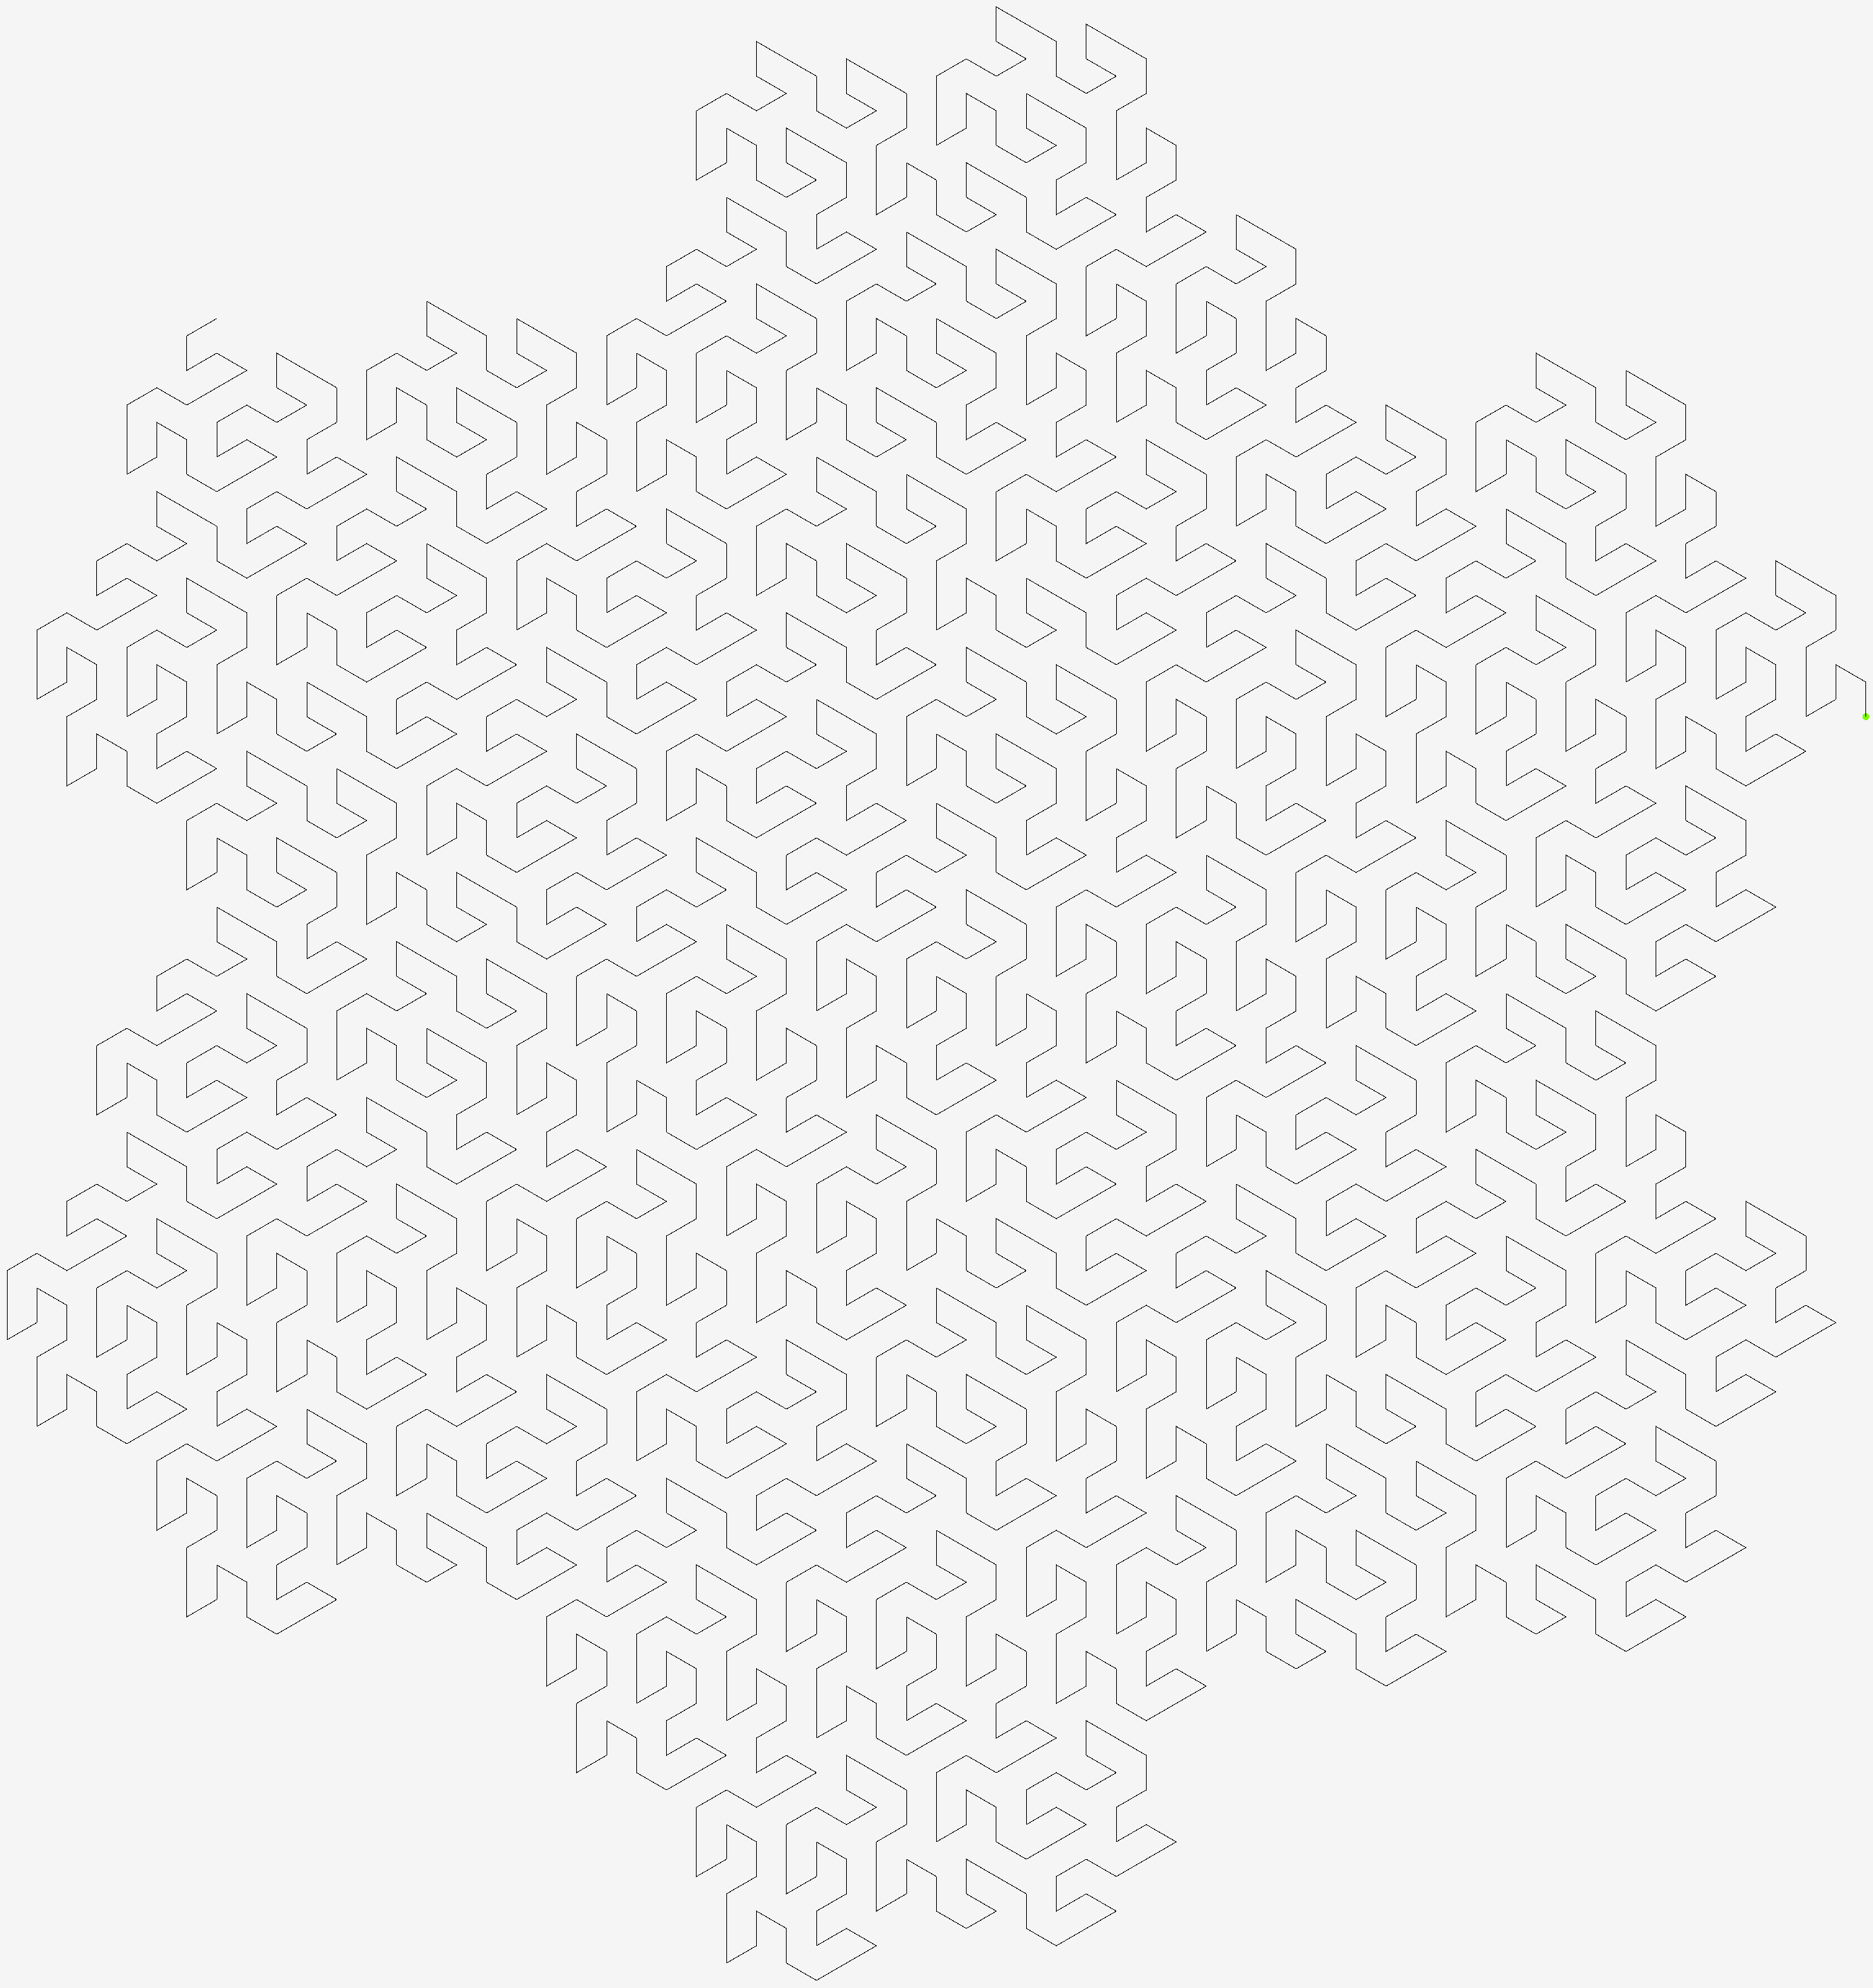

In [113]:
// Figure 1.11 (a)
let hexagonalGosperCurve =
    { Alphabet = ['L'; 'R'; '+'; '-']
      Axiom = "L"
      Productions =
        [ production ('L', "L+R++R-L--LL-R+")
          production ('R', "-L+RR++R+L--L-R") ] }

drawFASSTurtleSystem 4 {defaultTurtle with AngleIncrement = 60.0<degrees>} hexagonalGosperCurve